In [7]:
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import matplotlib.font_manager as fm
import datetime as dt
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import StandardScaler
import numpy as np
import konlpy
from konlpy.tag import Hannanum
import pandas as pd
import datetime
import re
from scipy.stats import norm

In [8]:

def read_kko_msg(filename):
    with open(filename, encoding='utf-8') as f:
        msg_list = f.readlines()
    return msg_list

def apply_kko_regex(msg_list):
    kko_pattern = re.compile("\[([\S\s]+)\] \[(오전|오후) ([0-9:\s]+)\] ([^\n]+)")
    kko_date_pattern = re.compile("--------------- ([0-9]+년 [0-9]+월 [0-9]+일) ")

    emoji_pattern = re.compile("["u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               "]+", flags=re.UNICODE)

    kko_parse_result = list()
    cur_date = ""

    for msg in msg_list:
        # 날짜 부분인 경우
        if len(kko_date_pattern.findall(msg)) > 0:
            cur_date = datetime.datetime.strptime(kko_date_pattern.findall(msg)[0], "%Y년 %m월 %d일")
            cur_date = cur_date.strftime("%Y-%m-%d")
        else:
            kko_pattern_result = kko_pattern.findall(msg)
            if len(kko_pattern_result) > 0:
                tokens = list(kko_pattern_result[0])
                # 이모지 데이터 삭제
                tokens[-1] = re.sub(emoji_pattern, "", tokens[-1])
                tokens.insert(0, cur_date)
                kko_parse_result.append(tokens)

    kko_parse_result = pd.DataFrame(kko_parse_result, columns=["Date", "User", "timetype", "Time", "Message"])
    kko_parse_result.to_csv("kko_regex.csv", index=False)

    return kko_parse_result

if __name__ == '__main__':
    msg_list = read_kko_msg("kakao.txt")
    apply_kko_regex(msg_list)
    
df = pd.read_csv("kko_regex.csv")
df.head()
len(df)

1101

In [9]:
def data_pre_cleansing(df):
    df.Date = pd.to_datetime(df.Date)
    ## 24시간제 표기
    df["24time"] = df["timetype"] + " " + df["Time"]
    df["24time"] = df["24time"].map(lambda x : x.replace("오전","AM"))
    df["24time"] = df["24time"].map(lambda x : x.replace("오후","PM"))

    temp = []
    transform_time = []
    for i in range(len(df)) :
        time = df["24time"][i]
        temp.append(datetime.datetime.strptime(time,"%p %I:%M"))
        transform_time.append(temp[i].time())

    df["24time"] = transform_time
    df = df.astype(str)
    df["Date"] = df["Date"] +" "+ df["24time"]
    df.drop("Time",axis=1,inplace=True)
    return df
def data_cleansing_date(df):
    # 문자열 형태로 되어 있는 날짜 데이터를 datetime 형태로 변환시켜준다.
    df["Date"] = pd.to_datetime(df["Date"],format= "%Y-%m-%d %H:%M:%S")
    weekday = ["월요일","화요일","수요일","목요일","금요일","토요일","일요일"]
    df["Year"] = df["Date"].apply(lambda x : x.year)
    df["Month"] =  df["Date"].apply(lambda x : x.month)
    df["Day"] =  df["Date"].apply(lambda x : x.day)
    df["Weekday"] =  df["Date"].apply(lambda x : weekday[x.weekday()])
    df["len"] = df["Message"].apply(lambda x : len(x))
    df["hour"] = df["Date"].apply(lambda x : x.hour)
    df["minute"] = df["Date"].apply(lambda x : x.minute)
    df = df[['Date', 'Year', 'Month', 'Day', 'Weekday', '24time','hour','minute','timetype', 'len', 'User', 'Message']]
    df["Delta"] = df["Date"].shift(-1) - df["Date"]
    return df
def data_cleansing_text(df):
    # 이메일 주소 -> '메일주소'로 변환하기
    pattern = '([a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+)'
    df["Message"] = df["Message"].str.replace(pattern,'메일주소')
    # 링크 -> '링크로 변환하기'
    df["Message"] = df["Message"].apply(lambda x : re.sub(r'^https?:\/\/.*[\r\n]*', '링크',x))
    df["len"] = df["Message"].apply(lambda x : len(x))
    return df
def data_cleansing_text_1(df):
    pattern = '[^\w\s]'
    df["Message"] = df["Message"].apply(lambda x : re.sub(pattern,"",x))
    pattern = '([ㄱ-ㅎㅏ-ㅣ]+)'
    df["Message"] = df["Message"].apply(lambda x : re.sub(pattern,"",x))
    return df
#from hanspell import spell_checker


def remove_stopwords(text):
    tokens = text.split(" ")
    stopwords = ['수', '현', '있는', '있습니다', '그', '년도', '합니다', '하는', '쟂','띨','삭제된 메시지입니다','샵검색',
             '및', '제', '할', '하고', '더', '한', '그리고', '월','근데','진짜','너무','아니','다시','내가',
             '저는', '없는', '입니다', '등', '일', '많은', '이런', '것은','저희', '네네', '넵넵',"이모티콘","건가요",
            "그냥","거기","지금","이제","우리","일단","한번","나도","하는","그게","약간","그거","해서","재미","뭔가",
            "존나", "누가", "하기", "하는데", "거의", "할게", "이번", "이건", "사실", "정도", "갑자기", "혹시","이거","네넵"]
    meaningful_words = [i for i in tokens if not i in stopwords ]
    return " ".join(meaningful_words)

#df["NM"] = df["Message"].apply(remove_stopwords)

han = Hannanum()
def morphs(df):
    stopwords = ['수', '현', '있는', '있습니다', '그', '년도', '합니다', '하는', '쟂','띨','삭제된 메시지입니다','샵검색',
             '및', '제', '할', '하고', '더', '한', '그리고', '월','근데','진짜','너무','아니','다시','내가',
             '저는', '없는', '입니다', '등', '일', '많은', '이런', '것은','저희', '네네', '넵넵',"일단","이거","네넵"]
    
    df["pos"] = df["NM"].apply(lambda x : han.pos(x))
    #df["proverb"] = df["pos"].apply(lambda x :[str(key) for key,value in x if value == "P"])
    
    # 명사 열을 만들 때 1개 짜리 명사 제거하고, stopwords 명사 제거
    df["nouns"] = df["pos"].apply(lambda x : [str(key) for key,value in x if value == "N" 
                                             if not len(str(key)) == 1 if not str(key) in stopwords ])
    return df
def data_cleansing_sum(df):
    df = data_pre_cleansing(df)
#    print("1end")
    df = data_cleansing_date(df)
#    print("2end")
    df = data_cleansing_date(df)
#    print("3end")
    df = data_cleansing_text(df)
#    print("4end")
    df = data_cleansing_text_1(df)
#    print("5end")
#    df = spell_check(df)
    df["NM"] = df["Message"].apply(remove_stopwords)
#    print("6end")
    
    df= morphs(df)

    return df

In [10]:
df = data_cleansing_sum(df)

In [11]:
df.head()

,Date,Year,Month,Day,Weekday,24time,hour,minute,timetype,len,User,Message,Delta,NM,pos,nouns
0,2021-02-13 17:18:00,2021,2,13,토요일,17:18:00,17,18,오후,4,링커리어 이정민님,,00:00:00,,[],[]
1,2021-02-13 17:18:00,2021,2,13,토요일,17:18:00,17,18,오후,5,김유빈,안녕하세요,00:00:00,안녕하세요,"[(안녕하세요, N)]",[안녕하세요]
2,2021-02-13 17:18:00,2021,2,13,토요일,17:18:00,17,18,오후,27,김유빈,건국대학교 3학년 산업공학과 김유빈이라고 합니다,00:02:00,건국대학교 3학년 산업공학과 김유빈이라고,"[(건국대학교, N), (3학년, N), (산업공학, N), (과, J), (김유빈...","[건국대학교, 3학년, 산업공학, 김유빈]"
3,2021-02-13 17:20:00,2021,2,13,토요일,17:20:00,17,20,오후,62,경수,안녕하세요 저는 연세대 디지털애널리틱스 석사과정에 있고 랩은 산업공학과 소속이에요 ...,00:00:00,안녕하세요 연세대 디지털애널리틱스 석사과정에 있고 랩은 산업공학과 소속이에요 김경수...,"[(안녕, N), (하, X), (세, E), (요, J), (연세대, N), (디...","[안녕, 연세대, 디지털애널리틱스, 석사과정, 산업공학, 소속, 김경수, 3학기]"
4,2021-02-13 17:20:00,2021,2,13,토요일,17:20:00,17,20,오후,42,링커리어 이정민님,안녕하세요 저는 UCL PPE 3학년이고 현재 막학기 다니고 있습니다,00:04:00,안녕하세요 UCL PPE 3학년이고 현재 막학기 다니고,"[(안녕, N), (하, X), (세, E), (요, J), (UCL, F), (P...","[안녕, 3학년, 막학기]"


### 시간대별 채팅 시각화 time_all_chat 함수
- sns의 lineplot을 이용해서 시간대별 카톡 횟수를 시각화할 수 있다
- 전체 톡방의 시간대별 카톡 횟수를 알 수 있다

In [12]:
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

In [13]:
def time_all_chat(df):
    df_cnt_hour = df[["hour","User"]].groupby(["hour"]).agg({"User":"count"}).reset_index()
    ax = sns.lineplot(x="hour",y="User",data=df_cnt_hour)
    ax.set_xlabel("hour")
    ax.set_ylabel("frequency")
    ax.set_title("전체 톡방 시간대별 채팅횟수")
    plt.grid(False)
    plt.show()
    # 전체 톡방 시간대별 카톡횟수를 출력

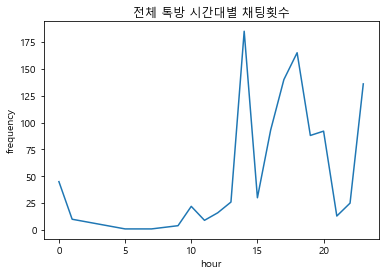

In [14]:
time_all_chat(df)

In [15]:
# return이 json 파일인 경우
def time_all_chat(df):
    res_df = df[["hour","User"]].groupby(["hour"]).agg({"User":"count"}).reset_index()
    res_df = res_df.rename(columns={"User":"count"})
    res_df = res_df.set_index("hour")
    return res_df

In [16]:
time_all_chat(df)

,count
hour,
0,45
1,10
5,1
7,1
9,4
10,22
11,9
12,16
13,26


### 시간대별 채팅 시각화 time_member_chat 함수
- 멤버별로 어느 시간대에 채팅을 많이 하는지 한눈에 알 수 있다

In [17]:
# 멤버별 시간대별 채팅을 dataframe에 합쳐서 json으로 내보내기
# left outer join 이용

def time_member_chat(df):
    users = df["User"].value_counts().index
    res_df = pd.DataFrame(data=[i for i in range(24)],index=[i for i in range(24)],columns=["hour"])

    for i in range(len(users)):
        df_ = df[df["User"] == users[i]][["User","hour"]].groupby(["hour"]).agg({"User":"count"}).reset_index()
        df_ = df_.rename(columns={"User":("User "+str(i))})
        res_df = pd.merge(left=res_df,right=df_,on="hour",how="left")
    res_df = res_df.fillna(0)
    res_df = res_df.astype(int)
    return res_df
    
#    with open('time_member_chat.json', 'w', encoding='utf-8') as file:
#        return res_df.to_json(file, force_ascii=False)

In [18]:
time_member_chat(df)

,hour,User 0,User 1,User 2,User 3,User 4,User 5
0,0,20,1,15,8,0,1
1,1,9,0,0,1,0,0
2,2,0,0,0,0,0,0
3,3,0,0,0,0,0,0
4,4,0,0,0,0,0,0
5,5,0,1,0,0,0,0
6,6,0,0,0,0,0,0
7,7,0,1,0,0,0,0
8,8,0,0,0,0,0,0
9,9,0,0,4,0,0,0


### 시간대별 채팅 시각화해보기

- 각 인물별 시간대별 kdeplot 커널밀도함수
- 단순히 횟수로 따지는 것보다는 개인이 어떤 시간대를 많이 이용하는지 보기 위해 커널밀도함수 이용

In [19]:

def time_all_chat_kdeplot(df):
    users = df["User"].value_counts().index
    fig,ax = plt.subplots(figsize=(10,5))
    for i in range(len(users)):
        ax = sns.kdeplot(df["hour"][(df["User"] == users[i]) & (df["hour"].notnull())],ax=ax,label=users[i],shade=False,bw=1.0)
    ax.set_xlabel("hour")
    ax.set_ylabel("frequency")
    ax.set_yticks([])
    plt.title("시간대별 채팅 밀도함수")

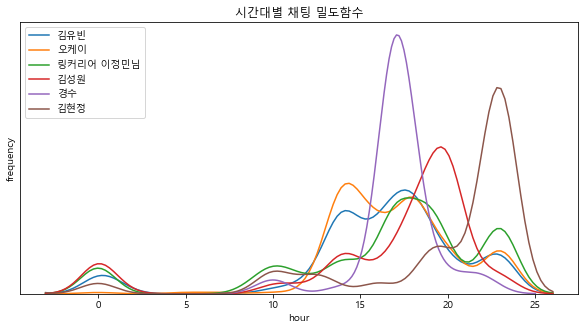

In [20]:
time_all_chat_kdeplot(df)

### 협조성 ( 완료 )

- 전체 톡방이 활성화되는 시간에 얼마나 잘 참여하는지 평가해보자
- 전체 대화방이 활발해지는 시간에 대한 비율을 하나의 가중치로 만들고
- 대화 하나가 가지는 가치가 시간 마다 다른 것이다. 전체 톡방이 활성화 될 때 이야기하는 대화가 더 가치있다고 판단하는 것
- 전체 대화방에서 대화가 가장 활발한 시간대 별 비율을 적고, 이것을 시간대 별 점수(가중치로) 설정
- A가 한 대화*어떤 시간인지 그 비율 / 전체 대화수  => 평균적인 대화의 점수?

In [21]:
def cooperation(df):
    std = StandardScaler()
    users = df["User"].value_counts().index
    # users 변수에는 카카오톡방 대화자들이 들어간다
    users_coop_score = []
    total_cnt = len(df)
    # total_cnt에는 전체 톡방 대화수
    
    series = (df["hour"].value_counts()/total_cnt)
    # series 에는 대화 시간대별 가중치
    
    df_series = df[["User","hour"]]
    series = series.reset_index().rename(columns={"index":"hour","hour":"weight"})
    df_series = pd.merge(left=df_series,right=series,how="inner",on="hour")
    # df_series에는 각 시간대 카톡별 가중치가 적힌 dataframe이다
    
    for i in users:
        users_coop_score.append(df_series[df_series["User"] == i]["weight"].mean())
    # res_df 에는 유저별 평균적인 가중치 점수가 들어가게 된다
    users_coop_score = std.fit_transform(np.array(users_coop_score).reshape(-1,1))
    # min max scaler로 scaling 해주기
    
    res_df = pd.DataFrame(data=users_coop_score,index=users,columns=["User"])
    
    # 유저별 연관성 수치 백분위 구하기
    rv = norm(loc=0,scale=1)
    res_df["User"] = res_df["User"].apply(lambda x : int(round(rv.cdf(x),2)*100))
    
    return res_df
    
#    with open('cooperation_func.json', 'w', encoding='utf-8') as file:
#        return res_df.to_json(file, force_ascii=False)

In [22]:
cooperation(df)

,User
김유빈,66
오케이,92
링커리어 이정민님,21
김성원,16
경수,86
김현정,14


### 답장 시간 분석

- 관점 1 : 내가 다른 사람 카톡을 답장하기 까지의 간격으로 나의 적극성 판단
- 관점 2 : 내가 보낸 카톡이 다른 사람에 의해서 답장 받기 까지의 간격으로 보아 나의 카톡이 갑분싸 카톡인지 아닌지 판단

In [32]:
df_test = df[["Delta","Date","User","Message"]]

In [33]:
df_test["Interval"] = df_test["Delta"].apply(lambda x : x.seconds//60)
df_test["indifferent"] = (df_test["User"] != df_test["User"].shift(-1)) & (df_test["Interval"] >= 30)
# Delta 열에 있는 데이터는 .seconds나 .microseconds로 초나 마이크로 초를 구해서
# 초를 구한 다음에 분을 구할 수 있다
# Interval 열에는 해당 사람이 카톡을 보내고 나서의 다음 카톡이 올때까지 답장 간격을 분으로 나타낸다

In [34]:
df_test[df_test["indifferent"]]

,Delta,Date,User,Message,Interval,indifferent
118,2 days 03:46:00,2021-02-13 18:13:00,링커리어 이정민님,감사합니다 화요일에 뵐게요,226.0,True
165,2 days 02:33:00,2021-02-16 20:46:00,김유빈,링크,153.0,True
187,0 days 10:55:00,2021-02-18 23:51:00,김유빈,세종시 자체가 2005년에 국회에서 법이 통과되면서 시작됐더라고요,655.0,True
194,0 days 03:53:00,2021-02-19 10:51:00,링커리어 이정민님,빼먹은 게 있는지 한 번 다시 확인해볼게요 오늘이나 내일이요,233.0,True
202,0 days 19:42:00,2021-02-20 18:37:00,김유빈,저희 스크랩 어느 정도 진행된 것 같은데 혹시 추가적으로 진행할 수 있는 거 있을까요,1182.0,True
208,0 days 06:29:00,2021-02-21 14:50:00,김유빈,다른 분 혹시 연락 온 분 없나요,389.0,True
215,0 days 00:31:00,2021-02-21 21:47:00,김유빈,여기 은근 활발한 것 같은데 여기 글 한번 작성 부탁드려도 될까요,31.0,True
216,0 days 00:49:00,2021-02-21 22:18:00,링커리어 이정민님,네 제가 조금 이따 집 가서 바로 올릴게요,49.0,True
217,0 days 00:57:00,2021-02-21 23:07:00,김유빈,넵 감사합니다,57.0,True
238,0 days 18:03:00,2021-02-22 00:27:00,링커리어 이정민님,네 감사합니다,1083.0,True


In [ ]:
df_test

### 적극성 participation 함수 (완료)
- 하루는 1440분이니까
- 0분 ~ 60분의 대화는 1점
- 60분 ~ 120분의 대화는 23/24 = 0.958 점
- 이런 방식으로 대화에 가중치를 설정해서 그 사람이 가지는 대화의 점수의 합을 구하자

- return json 버전
- return dataframe 버전

In [23]:
def participation(df):
    standard = StandardScaler()
    users_parti_score = []
    # user 별 적극성 점수가 들어간다
    df["Date"] = pd.to_datetime(df["Date"],format= "%Y-%m-%d %H:%M:%S")
    df["Delta"] =  df["Date"] - df["Date"].shift(1)
    
    df_test = df[["Delta","Date","User"]]
    df_test["Interval"] = df_test["Delta"].apply(lambda x : x.seconds//60)
    df_test["indifferent"] = (df_test["User"] != df_test["User"].shift(1))

    # 각자 답장간격이 어느정도 되는지 확인해보기
    test = df_test[df_test["indifferent"]][["User","Interval"]].fillna(0)
    test = test.reset_index(drop=True)
    # test 에는 User 별 Interval이 들어가 있다
    
    weight = []
    for j in range(len(test)):
        for i in range(24):
            if i*60 <= test.loc[j,"Interval"] < (i+1)*60:
                weight.append((24-i)/24)
    test = test.assign(weight = weight)
    # test 에 User 별 Interval에 따른 Weight 추가해주기
    
    # User 목록
    users = test["User"].value_counts().index
    
    # User 별 점수
    for i in users:
        users_parti_score.append(test[test["User"] == i]["weight"].sum())
    
    # 결과값 StandardScaling
    users_parti_score = standard.fit_transform(np.array(users_parti_score).reshape(-1,1))
    
    # DataFrame으로 내보내기
    res_df = pd.DataFrame(data=users_parti_score,index=users,columns=["User"])
    
    # 유저별 연관성 수치 백분위 구하기
    rv = norm(loc=0,scale=1)
    res_df["User"] = res_df["User"].apply(lambda x : int(round(rv.cdf(x),2)*100))
    
    return res_df
    
#    with open('participation_func.json', 'w', encoding='utf-8') as file:
#        return res_df.to_json(file, force_ascii=False)

In [24]:
participation(df)

,User
김유빈,97
오케이,66
링커리어 이정민님,52
김성원,34
경수,18
김현정,14


In [25]:
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

In [26]:
def member_chat_interval(df):

    df = df[["Delta","Date","User"]]
    df["Interval"] = df["Delta"].apply(lambda x : x.seconds//60)
    df["indifferent"] = (df["User"] != df["User"].shift(1))

    # 각자 답장간격이 어느정도 되는지 확인해보기

    test = df[df["indifferent"]][["User","Interval"]].fillna(0)
    users = df["User"].value_counts().index
    for i in range(len(users)):
        sns.set_style("whitegrid")
        sns.set(font_scale=1.5)
        ax = sns.distplot(test[test["User"] == users[i]]["Interval"],hist=False,color="Orange")
        ax.set_title("User "+str(i)+" Chat Interval")
        ax.set_xlim([0,1440])
        #plt.grid(False)
        plt.show()
    # test 에는 User 별 Interval이 들어가 있다

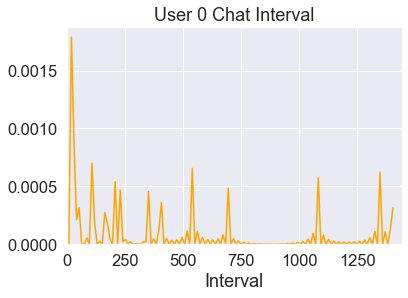

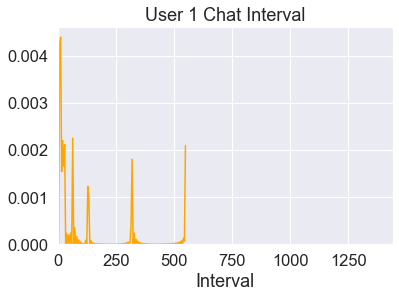

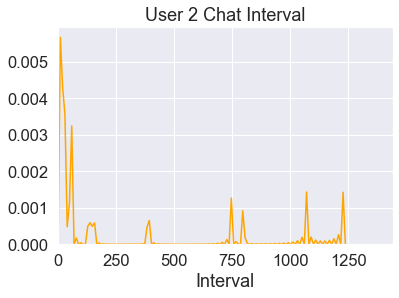

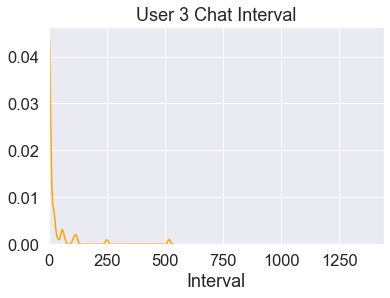

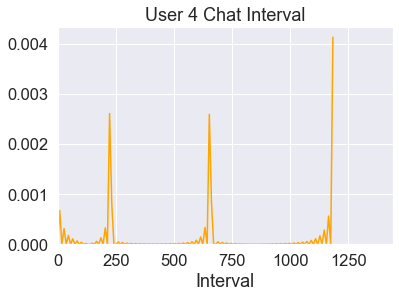

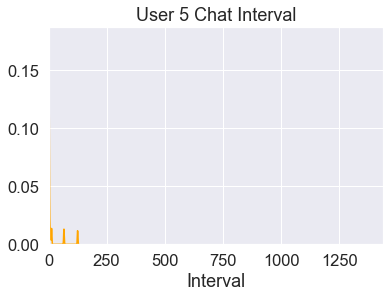

In [27]:
member_chat_interval(df)

In [29]:
# plt 대신 dataframe으로 내보내기
def member_chat_interval(df):
    df = df[["Delta","Date","User"]]
    df["Interval"] = df["Delta"].apply(lambda x : x.seconds//60)
    df["indifferent"] = (df["User"] != df["User"].shift(1))

    df = df[df["indifferent"]][["User","Interval"]].fillna(0).reset_index(drop=True)
    df["Interval"] = df["Interval"].astype(int)
    users = df["User"].value_counts().index

    time = []
    for i in range(24):
        hour = str(i*60)+" ~ "+str((i+1)*60)+"분"
        time.append(hour)
    res_df = pd.DataFrame(data=0,index = users,columns = [k for k in range(24)])

    for j in users:
        for i in range(len(df)):
            if j == df.loc[i,"User"]:
                num = df.loc[i,"Interval"] // 60
                res_df.loc[j,num]+=1
                
    res_df.columns = time
    
    return res_df

In [30]:
member_chat_interval(df)

,0 ~ 60분,60 ~ 120분,120 ~ 180분,180 ~ 240분,240 ~ 300분,300 ~ 360분,360 ~ 420분,420 ~ 480분,480 ~ 540분,540 ~ 600분,...,840 ~ 900분,900 ~ 960분,960 ~ 1020분,1020 ~ 1080분,1080 ~ 1140분,1140 ~ 1200분,1200 ~ 1260분,1260 ~ 1320분,1320 ~ 1380분,1380 ~ 1440분
김유빈,206,2,1,2,0,1,1,0,0,1,...,0,0,0,0,1,0,0,0,1,1
오케이,114,1,1,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
링커리어 이정민님,90,1,2,0,0,0,1,0,0,0,...,0,0,0,1,0,0,1,0,0,0
김성원,61,3,1,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
경수,33,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
김현정,23,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


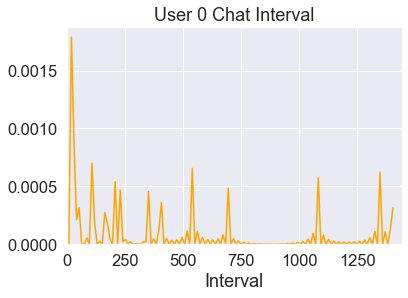

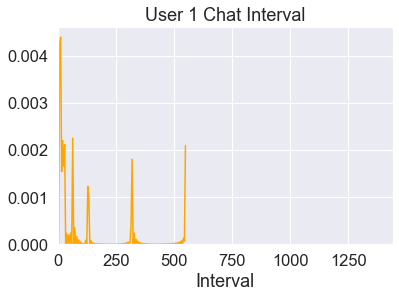

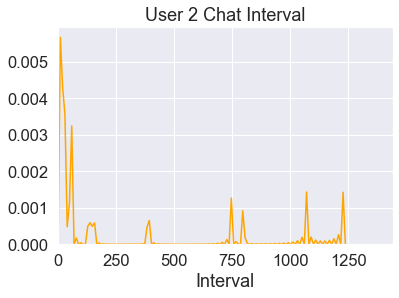

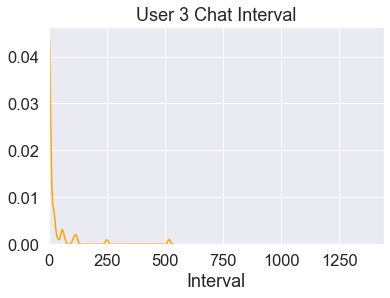

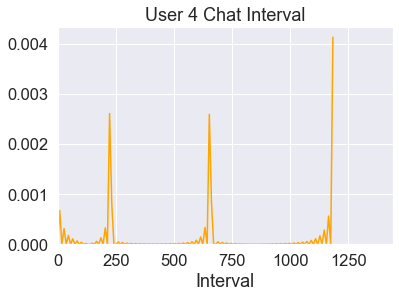

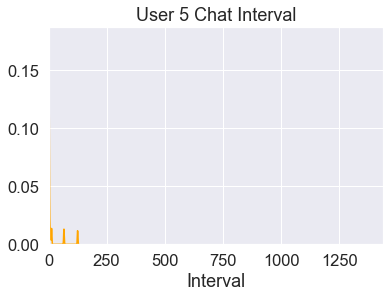

In [30]:
member_chat_interval(df)

In [31]:
def all_member_chat_interval(df):
    res_df = df[["Delta","Date","User"]]
    res_df["Interval"] = res_df["Delta"].apply(lambda x : x.seconds//60)
    res_df["indifferent"] = (res_df["User"] != res_df["User"].shift(1))
    res_df = res_df[res_df["indifferent"]][["Interval"]].fillna(0)
    res_df = res_df.reset_index(drop=True)
    res_df = res_df.astype(int)
    
    return res_df
    
#    with open('all_member_chat_interval_func.json', 'w', encoding='utf-8') as file:
#        return res_df.to_json(file, force_ascii=False)

In [32]:
all_member_chat_interval(df)

,Interval
0,0
1,0
2,2
3,0
4,1
...,...
557,1
558,1228
559,19
560,540


### word_cloud 함수
- 상위 n_top 개의 빈도수를 가지는 명사만 출력

In [34]:
df.head(3)

,Date,Year,Month,Day,Weekday,24time,hour,minute,timetype,len,User,Message,NM,pos,proverb,nouns,Delta
0,2021-02-13 17:18:00,2021,2,13,토요일,17:18:00,17,18,오후,5,링커리어 이정민님,안녕하세요,안녕하세요,"[(안녕하세요, N)]",[],[안녕하세요],NaT
1,2021-02-13 17:18:00,2021,2,13,토요일,17:18:00,17,18,오후,5,김유빈,안녕하세요,안녕하세요,"[(안녕하세요, N)]",[],[안녕하세요],0 days
2,2021-02-13 17:18:00,2021,2,13,토요일,17:18:00,17,18,오후,26,김유빈,건국대학교 3학년 산업공학과 김유빈이라고 합니다,건국대학교 3학년 산업공학과 김유빈이라고,"[(건국대학교, N), (3학년, N), (산업공학, N), (과, J), (김유빈...",[],"[건국대학교, 3학년, 산업공학, 김유빈]",0 days


In [33]:

def word_cloud(df,n_top):
    # n_top은 상위 몇 개의 명사들을 출력할지
    
    # words 변수에는 명사들만 담긴다
    words = [j for row in df["nouns"] for j in row]
    
    # words_dict에는 Count를 기준으로 한 명사가 담겨있음
    words_dict = dict(Counter(words))
    
    words_dict = dict(sorted(words_dict.items(), key=lambda x: x[1], reverse=True)[:n_top])
    # 빈도수 상위 n개의 단어들만 wordcloud 형태로 시각화하기

    wordcloud = WordCloud(font_path="NanumGothic.ttf",width=500,height=500,background_color="white").generate_from_frequencies(words_dict)
    plt.figure(figsize=(10,10))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

In [34]:
def word_cloud(df,n_top):
    words = [j for row in df["nouns"] for j in row]
    words_dict = dict(Counter(words))
    words_dict = dict(sorted(words_dict.items(), key=lambda x: x[1], reverse=True)[:n_top])
    res_df = pd.DataFrame(data=words_dict.keys(),columns=["word"])
    res_df["count"] = words_dict.values()
    
    # word 열에는 단어 , count 열에는 단어의 개수가 적힌 dataframe -> json
    
    return res_df
#    with open('word_cloud_func.json', 'w', encoding='utf-8') as file:
#        return res_df.to_json(file, force_ascii=False) 

In [35]:
word_cloud(df,30)

,word,count
0,데이터,80
1,사진,45
2,전처리,34
3,파일,28
4,감사,26
5,링크,25
6,생각,23
7,분석,21
8,모델,20
9,사용,19


### 연관성 relation 함수

- 주제 키워드가 대화에 얼마나 많이 포함되어있는지
- 토픽 모델링 혹은 wordcloud로 추출한 키워드들이 얼마나 포함되어있는지 확인
- 만약 키워드 a 를 100개 만큼 가지고 있다면 전체에서 a 라는 키워드의 비율 * 100 으로 그 사람의 연관성 점수
- user열과 nouns열이 들어간다
- nouns 열은 리스트 형태로 명사들이 저장된다

In [36]:
def relation(df):
    
    df["weight"] = 0
    # df_test 는 User별로 사용한 명사들과 가중치의 총합이 담긴다
    standard = StandardScaler()
    users_relate_score = []
    
    words = [j for row in df["nouns"] for j in row]
    # words_dict에는 Count를 기준으로 한 명사가 담겨있음
    words_dict = dict(Counter(words))
    
    # dict_df는 명사별 Count와 Weight 정보가 담겨있음
    dict_df = pd.DataFrame(index=words_dict.keys(),data=words_dict.values(),columns=["count"])
    dict_df["weight"] = dict_df["count"].apply(lambda x : x / dict_df.sum())
    
    # 대화별 명사 가중치 합 구하기
    for i in range(len(df)):
        weight=0
        for j in df.loc[i,"nouns"]:
            weight+=dict_df.loc[j,"weight"]
        df.loc[i,"weight"] = weight
    
    # 유저목록
    users = df["User"].value_counts().index
    
    # 유저별 연관성 수치 구하기
    for i in users:
        users_relate_score.append(df[df["User"] == i]["weight"].sum())
    
    # 유저별 연관성 수치  
    users_relate_score = standard.fit_transform(np.array(users_relate_score).reshape(-1,1))
    
    res_df = pd.DataFrame(data=users_relate_score,columns=["User"],index=users)
    
    # 유저별 연관성 수치 백분위 구하기
    rv = norm(loc=0,scale=1)
    res_df["User"] = res_df["User"].apply(lambda x : int(round(rv.cdf(x),2)*100))
    
    return res_df
#    with open('relation_func.json', 'w', encoding='utf-8') as file:
#        return res_df.to_json(file, force_ascii=False)

In [37]:
relation(df)

,User
김유빈,97
오케이,69
링커리어 이정민님,52
김성원,38
경수,16
김현정,14


### 근로성 지표

In [38]:
def workability(df):
    standard = StandardScaler()
    mean_len = int(df["len"].mean())
    res_df = pd.DataFrame(data=(df[["User","len"]]),columns=["User","len"])
    res_df["len"] = res_df["len"] / mean_len
    res_df = res_df.groupby(["User"]).agg({"len":"sum"})
    
    res_df["len"] = standard.fit_transform((res_df["len"].values).reshape(-1,1))
    
    rv = norm(loc=0,scale=1)
    res_df["len"] = res_df["len"].apply(lambda x : int(round(rv.cdf(x),2)*100))
    res_df = res_df.rename(columns={"len":"User"})
    res_df.index.name=''
    return res_df

workability(df)

,User
,
경수,16
김성원,39
김유빈,96
김현정,11
링커리어 이정민님,63
오케이,66


In [21]:
if __name__ == '__main__':
    msg_list = read_kko_msg("kakao.txt")
    apply_kko_regex(msg_list)
    df = pd.read_csv("kko_regex.csv")

    df = data_pre_cleansing(df)
    df = data_cleansing_date(df)
    df = data_cleansing_text(df)
    df = data_cleansing_text_1(df)
    df = spell_check(df)
    df["NM"] = df["Message"].apply(remove_stopwords)
    df = morphs(df)
### 여기까지 전처리 ###
    time_all_chat = dict(time_all_chat(df))

    time_member_chat=dict(time_member_chat(df))

    cooperation=dict(cooperation(df))

    participation=dict(participation(df))

    member_chat_interval=dict(member_chat_interval(df))

    all_member_chat_interval=dict(all_member_chat_interval(df))

    word_cloud=dict(word_cloud(df,50))

    relation=dict(relation(df))

    workability=dict(workability(df))

    analyze_result = {}
    analyze_result = {
        'time_all_chat': time_all_chat,
        'time_member_chat': time_member_chat,
        'cooperation': cooperation,
        'participation' : participation,
        'member_chat_interval' : member_chat_interval,
        'all_member_chat_interval' : all_member_chat_interval,
        'word_cloud' : word_cloud,
        'relation': relation,
        'workability': workability
    }

TypeError: 'dict' object is not callable

In [39]:
def activity_show(df):
    standard = StandardScaler()
    def count_send_picture(df):
        df = df[df['Message'].str.contains('사진')]
        df = df['User'].value_counts(dropna=True, sort=True)
        df = pd.DataFrame(df)
        df = df.reset_index()
        df.columns = ['User', 'Activity']
        df_pic = df
        return df_pic

    def count_send_file(df):
        df = df[df['Message'].str.contains('파일')]
        df = df['User'].value_counts(dropna=True, sort=True)
        df = pd.DataFrame(df)
        df = df.reset_index()
        df.columns = ['User', 'Activity']
        df_file = df
        return df_file
    df_f = pd.concat([count_send_file(df), count_send_picture(df)]).groupby(['User']).sum().reset_index()
    total = df_f["Activity"].sum()
    df_f["Activity"] = df_f["Activity"] / total
    df_f["Activity"] = standard.fit_transform(df_f["Activity"].values.reshape(-1,1))
    rv = norm(loc=0,scale=1)
    df_f["Activity"] = df_f["Activity"].apply(lambda x : int(round(rv.cdf(x),2)*100))
    
    return df_f

In [40]:
activity_show(df)

,User,Activity
0,경수,18
1,김성원,35
2,김유빈,96
3,김현정,23
4,링커리어 이정민님,25
5,오케이,82
